In [1]:
pip install lightfm

     |████████████████████████████████| 317kB 14.4MB/s 
  Created wheel for lightfm: filename=lightfm-1.16-cp37-cp37m-linux_x86_64.whl size=697404 sha256=9051988fe40a320966f536a275f956c5dcfa1b27707888c7fbcdf7b41231af29
  Stored in directory: /root/.cache/pip/wheels/c6/64/d4/673c7277f71ac4c5ad4835b94708c01b653ef2d3aa78ef20aa
Successfully built lightfm


In [2]:
# import libraries
from copy import deepcopy

import itertools

from lightfm import LightFM
from lightfm.evaluation import auc_score, precision_at_k
from lightfm.cross_validation import random_train_test_split

from matplotlib import pyplot as plt

import numpy as np

import pandas as pd

from scipy.sparse import csr_matrix
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import LabelEncoder

pd.set_option("max.columns", None)

import warnings
warnings.filterwarnings("ignore")

In [3]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [4]:
df = pd.read_csv('gdrive/My Drive/job/ratings.csv')

In [5]:
# EDA

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 93329 entries, 0 to 93328
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   user_id     93329 non-null  int64  
 1   product_id  93296 non-null  float64
 2   rating      93329 non-null  int64  
dtypes: float64(1), int64(2)
memory usage: 2.1 MB


In [7]:
#found 3000 duplicates
df[df.duplicated()]

,user_id,product_id,rating
1,8765713110,1.623200e+12,10
2,8765713110,1.623200e+12,10
3,8765713110,1.623200e+12,10
4,8765713110,1.623200e+12,10
8,8765713110,1.623200e+12,9
...,...,...,...
93100,96854724780,6.652259e+11,10
93150,440533159092,1.663416e+10,7
93196,410360450104,1.300653e+12,8
93200,395679429243,9.718234e+09,8


In [8]:
# removed duplicates, keeping the first of the duplicates
df = df.drop_duplicates(keep="first")

In [9]:
# finding null values
df[df["product_id"].isna()]

,user_id,product_id,rating
4375,190944716400,NaN,6
4477,53064088275,NaN,7
8680,156087835176,NaN,7
9317,34803492348,NaN,8
15267,24257413050,NaN,7
17627,213903919380,NaN,7
18173,94512206592,NaN,6
32269,433781750208,NaN,6
32791,34096916028,NaN,2
35220,183795222312,NaN,8


In [10]:
# choosing to keep the nulls - assuming a prdocut_id wasn't labeled right
df["product_id"].value_counts()

9.680483e+11    1281
6.282665e+11     811
9.876884e+09     549
3.233516e+09     476
4.908337e+09     473
                ... 
1.264997e+12       1
9.772420e+11       1
5.287477e+11       1
1.143797e+12       1
4.054371e+10       1
Name: product_id, Length: 3913, dtype: int64

In [11]:
# random number
df = df.fillna(2.3429352029385)

In [12]:
df

,user_id,product_id,rating
0,8765713110,1.623200e+12,10
5,8765713110,3.534724e+11,9
6,8765713110,1.623200e+12,9
7,8765713110,1.352859e+12,9
12,8765713110,1.259833e+12,9
...,...,...,...
93324,339223994897,4.569589e+11,8
93325,339223994897,7.906555e+11,8
93326,339223994897,1.406024e+12,8
93327,339223994897,3.394940e+11,7


In [13]:
# viewing ratings value
df["rating"].value_counts()

8     36191
7     19983
6     11347
9     10240
10     7058
5      2519
4      1674
2       658
3       334
Name: rating, dtype: int64

In [14]:
# checking shapes
df["product_id"].unique().shape

(3914,)

In [15]:
df["user_id"].unique().shape

(16838,)

In [16]:
df.groupby('user_id')['product_id'].count().mean()

5.345290414538543

In [17]:
# setting up the data to be modelled
ratings = 'rating'
users = 'user_id'
product = 'product_id'

ratings = np.array(df[ratings])
users = np.array(df[users])
product = np.array(df[product])

In [18]:
# heavy lifting encoders
user_encoder = LabelEncoder()
product_encoder = LabelEncoder()

# preparation for the csr matrix
u = user_encoder.fit_transform(users)
p = product_encoder.fit_transform(product)
lu = len(np.unique(u))
lp = len(np.unique(p))

In [19]:
interactions = csr_matrix((ratings, (u, p)), shape=(lu, lp))

In [20]:
# built this quick - simple way to set up future data
class InteractionMachine:
    def __init__(self):
        self.user_encoder = LabelEncoder()
        self.product_encoder = LabelEncoder()

    def __repr__(self):
        return 'InteractionMachine()'

    def build(self, users, items, ratings):
        u = self.user_encoder.fit_transform(users)
        p = self.product_encoder.fit_transform(product)
        self.n_users = len(np.unique(u))
        self.n_product = len(np.unique(p))
        self.interactions = csr_matrix((ratings, (u, p)), shape=(self.n_users, self.n_product))
        return self

In [21]:
im = InteractionMachine()

im.build(df['user_id'], df['product_id'], df['rating'])

interactions = im.interactions

In [22]:
interactions.toarray()

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int64)

In [23]:
# begin the modelling - using LightFM - basics
model = LightFM()

In [24]:
model.fit(interactions)

In [25]:
model.predict(0, [1, 2, 3])

array([0.2835276 , 0.18246694, 0.32236135], dtype=float32)

In [26]:
auc_score(model, interactions).mean()

0.84858984

In [27]:
precision_at_k(model, interactions, k=10).mean()

0.03169022

In [28]:
# splitting data - real model begins
train, test = random_train_test_split(interactions, test_percentage=0.2, random_state=13)

In [29]:
model = LightFM()
model.fit(train, epochs=500)

In [30]:
auc_score(model, test).mean()

0.83575296

In [31]:
# full block - base model to beat
model = LightFM(loss='warp')

scores = []
for e in range(50):
    model.fit_partial(train, epochs=1)
    auc_train = auc_score(model, train).mean()
    auc_test = auc_score(model, test).mean()
    scores.append((auc_train, auc_test))
    
scores = np.array(scores)

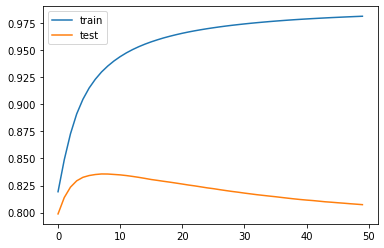

In [32]:
# shows overfitting
plt.plot(scores[:, 0], label='train')
plt.plot(scores[:, 1], label='test')
plt.legend()

In [33]:
# base models
model = LightFM(loss='warp')

count = 0
best = 0
scores = []
for e in range(100):
    if count > 5: # patience
        break
    model.fit_partial(train, epochs=1)
    auc_train = auc_score(model, train).mean()
    auc_test = auc_score(model, test).mean()
    print(f'Epoch: {e}, Train AUC={auc_train:.3f}, Test AUC={auc_test:.3f}')
    scores.append((auc_train, auc_test))
    if auc_test > best:
        model = deepcopy(model)
        best = auc_test
    else:
        count += 1

model = deepcopy(model)

Epoch: 0, Train AUC=0.825, Test AUC=0.806
Epoch: 1, Train AUC=0.851, Test AUC=0.819
Epoch: 2, Train AUC=0.875, Test AUC=0.829
Epoch: 3, Train AUC=0.894, Test AUC=0.836
Epoch: 4, Train AUC=0.907, Test AUC=0.840
Epoch: 5, Train AUC=0.917, Test AUC=0.842
Epoch: 6, Train AUC=0.925, Test AUC=0.843
Epoch: 7, Train AUC=0.931, Test AUC=0.843
Epoch: 8, Train AUC=0.937, Test AUC=0.843
Epoch: 9, Train AUC=0.941, Test AUC=0.843
Epoch: 10, Train AUC=0.945, Test AUC=0.842
Epoch: 11, Train AUC=0.948, Test AUC=0.841
Epoch: 12, Train AUC=0.951, Test AUC=0.841
Epoch: 13, Train AUC=0.954, Test AUC=0.840


In [34]:
# finding the best parameters on 200 samples
# this code was from stack overflow - customized to fit my situation

def sample_hyperparameters():
    """
    Yield possible hyperparameter choices.
    """

    while True:
        yield {
            "no_components": np.random.randint(8, 64),
            "learning_schedule": np.random.choice(["adagrad", "adadelta"]),
            "loss": np.random.choice(["bpr", "warp", "warp-kos"]),
            "learning_rate": np.random.exponential(0.05),
            "item_alpha": np.random.exponential(1e-8),
            "user_alpha": np.random.exponential(1e-8),
            "max_sampled": np.random.randint(5, 15),
            "num_epochs": np.random.randint(5, 50),
        }


def random_search(train, test, num_samples=200, num_threads=1):
    """
    Sample random hyperparameters, fit a LightFM model, and evaluate it
    on the test set.

    Parameters
    ----------

    train: np.float32 coo_matrix of shape [n_users, n_items]
        Training data.
    test: np.float32 coo_matrix of shape [n_users, n_items]
        Test data.
    num_samples: int, optional
        Number of hyperparameter choices to evaluate.


    Returns
    -------

    generator of (auc_score, hyperparameter dict, fitted model)

    """

    for hyperparams in itertools.islice(sample_hyperparameters(), num_samples):
        num_epochs = hyperparams.pop("num_epochs")

        model = LightFM(**hyperparams)
        model.fit(train, epochs=num_epochs, num_threads=num_threads)

        score = auc_score(model, test, train_interactions=train, num_threads=num_threads).mean()

        hyperparams["num_epochs"] = num_epochs

        yield (score, hyperparams, model)


if __name__ == "__main__":
    train = train
    test = test

    (score, hyperparams, model) = max(random_search(train, test, num_threads=2), key=lambda x: x[0])

    print("Best score {} at {}".format(score, hyperparams))

Best score 0.8528929352760315 at {'no_components': 22, 'learning_schedule': 'adadelta', 'loss': 'warp', 'learning_rate': 0.03736805420081851, 'item_alpha': 2.4888882516771975e-09, 'user_alpha': 7.573440641174502e-09, 'max_sampled': 6, 'num_epochs': 7}


In [35]:
model = LightFM(no_components = 22, learning_schedule = 'adadelta', loss = 'warp', learning_rate = 0.03736805420081851, item_alpha = 2.4888882516771975e-09, user_alpha = 7.573440641174502e-09, max_sampled = 6)

scores = []
for e in range(8):
    model.fit_partial(train, epochs=1)
    auc_train = auc_score(model, train).mean()
    auc_test = auc_score(model, test).mean()
    scores.append((auc_train, auc_test))
    
scores = np.array(scores)

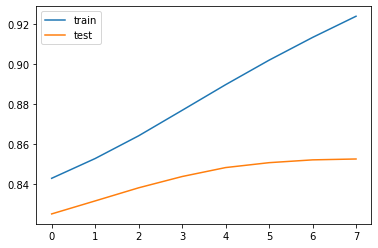

In [36]:
 # better fits
plt.plot(scores[:, 0], label='train')
plt.plot(scores[:, 1], label='test')
plt.legend()

In [37]:
model = LightFM(no_components = 22, learning_schedule = 'adadelta', loss = 'warp', learning_rate = 0.03736805420081851, item_alpha = 2.4888882516771975e-09, user_alpha = 7.573440641174502e-09, max_sampled = 6)

count = 0
best = 0
scores = []
for e in range(10):
    if count > 3: # patience
        break
    model.fit_partial(train, epochs=1)
    auc_train = auc_score(model, train).mean()
    auc_test = auc_score(model, test).mean()
    print(f'Epoch: {e}, Train AUC={auc_train:.3f}, Test AUC={auc_test:.3f}')
    scores.append((auc_train, auc_test))
    if auc_test > best:
        best_model = deepcopy(model)
        best = auc_test
    else:
        count += 1

model = deepcopy(best_model)

Epoch: 0, Train AUC=0.842, Test AUC=0.826
Epoch: 1, Train AUC=0.853, Test AUC=0.833
Epoch: 2, Train AUC=0.865, Test AUC=0.840
Epoch: 3, Train AUC=0.877, Test AUC=0.845
Epoch: 4, Train AUC=0.888, Test AUC=0.848
Epoch: 5, Train AUC=0.899, Test AUC=0.851
Epoch: 6, Train AUC=0.910, Test AUC=0.852
Epoch: 7, Train AUC=0.921, Test AUC=0.852
Epoch: 8, Train AUC=0.930, Test AUC=0.853
Epoch: 9, Train AUC=0.939, Test AUC=0.852


In [ ]:
## After building my recommendation algo using LightFM - you can see I beat the results from the assignment.